# Introduction to Kalman Filter

Originally developed in 1960 by R.E. Kalman, the Kalman filter provides an optimal estimate of how a system is going to change given noisy measurements and imperfect knowledge about the system. The Kalman filter is similar to least squares in many ways, but is a **sequential estimation** process rather than a batch one. It can be thought as a recursive formulation of the least squares method when the whole set of observations is partitioned into single measurements. As consequence, it is ideal for real-time applications as it has the advantage of operating on a sequential basis, taking measurements and processing them as they are available.



## Example - Sequential Estimation of a Static System 

To demonstrate how sequential estimation works, here we'll see how to estimate the state of a static system by repeating multiple measurements and fusing them into a single information. Imagine we need to measure the (constant) temperature of a body: in this case the system is the body, the unknown is its temperature. Since each measurement is affected by an unknown error, we decide to repeat the measurement process many times and to average the measurement to get their mean.

At the time of $k^{th}$ measurement the estimated value of the state is the average of all previously taken measurements:
#### $$ \hat{x}_{k}= \frac{1}{k} \left( y_{1}+ y_{2}+ \ldots + y_{k-1}+ y_{k} \right) = \frac{1}{k} \sum _{n=1}^{k} \left( y_{n} \right) $$


, where
- $ {y}_{k}  $ is the value of the $k^{th}$ measurement

- $ \hat{x}_{k} $ is the estimated value of the state after taking the measurement $ {y}_{k}  $

It can be demonstrated that:

#### $$ \hat{x}_{k}= \hat{x}_{k-1}+ \frac{1}{k} \left( y_{k}- \hat{x}_{k-1} \right) $$

From the above equation we can see that each estimate $\hat{x}_{k}$ depends on three factors: 

- the previous estimate $\hat{x}_{k-1}$,
- the new measurement $y_{k}$ and
- a weighting factor $1$$/$$k$, being $k$ the number of measurements

As we'll see later, this is one of the five equations characterizing the Kalman filter. It is called the **state update equation**; moreover, the weighting factor is called **Kalman gain** and defined as $K_k$:

#### $$ \hat{x}_{k}= \hat{x}_{k-1}+ K_k \left( y_{k}- \hat{x}_{k-1} \right) $$

So, the state update equation tells us how the estimate changes due to a new term (called **innovation**) which is nothing else than the residual of the new measurement multiplied by the Kalman gain, whose value in this case decreases as the number of measurements increase, limiting the impact on the newly calculated mean of each new incoming measurement.

Obviously, being this a recursive approach, we need an **initial guess** to start the process, which represents our first estimate of the unknown state.

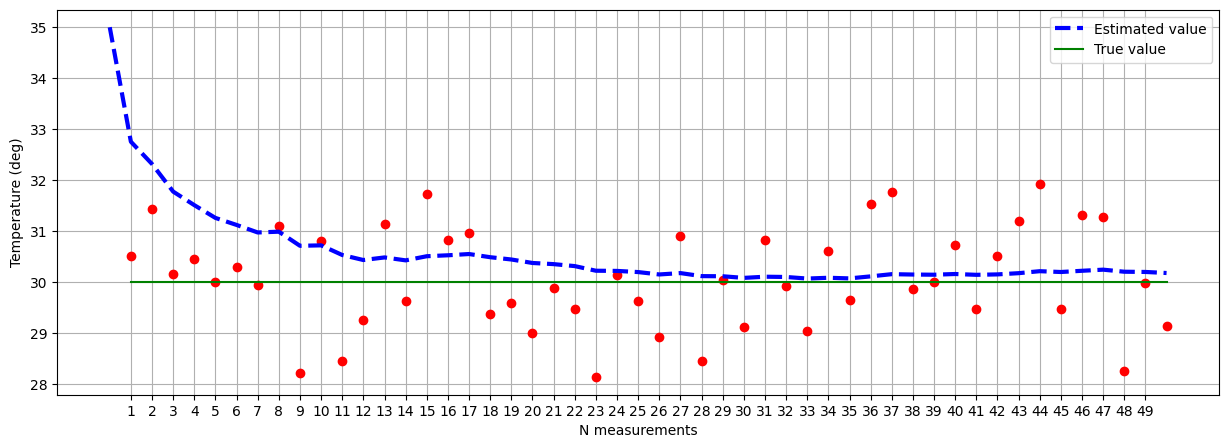

In [1]:
from estimation import *
########## meas model #############
trueTemp      = 30 # deg
oneSigma      = 1  # deg - uncertainty of the measuring device
nMeasurements = 50
###################################

########## input data #############
initialGuess  = 35 # deg 
###################################

StaticEstimator(trueTemp, oneSigma, nMeasurements, initialGuess)

## Kalman Filter Implementation

The above approach is implemented in the Kalman filter that, for each available measurement, iterates across two phases:

•	the **prediction** phase, which implements equations that describe the physical model of our system: from the current state (and its uncertainty) we can then predict which will be the next one (and the relevant uncertainty)

•	the **correction** (or **update**) phase, which uses the new measurements to apply the needed correction to the predicted epoch state according with the confidence level we have (measurement uncertainty)

<center><img src="Images/kalmanFilterProcess.png" alt="Drawing" style="width: 400px;"/><center>




### The Prediction Phase
In this phase the system's dynamic model is implemented. Starting from the assumption that the Kalman filter is discrete (we estimate the state when new measurements are available and this happens at discrete time steps), the simplest assumption we can do is that the state at time $t_{k+1}$ is somewhat function of the state at the previous time $t_k$. We already defined this kind of relationship using the **state transition matrix**:

#### $$\mathbf{x}_{k+1}=\mathbf{\Phi}(t_{k+1},t_k) \mathbf{x}_k$$


Differently from the least squares method (when we just consider the measurement errors as the unique source of uncertainty in the estimation process), in the Kalman filter we consider the uncertainty around the state to estimate *during* the estimation itself. This means that, defined $\mathbf{P}_k$ the **state covariance matrix** at time $t_k$, is it also integrated along time and its value is then *predicted* at time $t_{k+1}$ :

#### $$\mathbf{P}_{k+1}=\mathbf{\Phi}(t_{k+1},t_k) \mathbf{P}_{k} \mathbf{\Phi}(t_{k+1},t_k)^T$$

So, the state transition matrix plays a big role in the prediction phase, where it is used to propagate both the state and its covariance *in between* measurements.

From a formal notation perspective, we need to discriminate between this phase and the successive (the update) one, so from now on we'll write these two equations as

#### $$ \begin{matrix}
\mathbf{x}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{x}_k \\
\mathbf{P}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{P}_{k}^P \mathbf{\Phi}_{t_k}^T \end{matrix}$$

, where the upperscript $P$ means that this is the *predicted* value, and $\mathbf{\Phi}_{t_k}$ is the state transition matrix from $k$ to $k+1$


### The Correction (or Update) Phase
When a new measure is available, it is used to *correct* (or to *update*) the estimates calculated in the prediction phase. The first consider the state update equation already discussed above:

#### $$ \mathbf{x}_{k+1} = {x}_{k+1}^P +\mathbf{K}_{k+1} \left ( \mathbf{y}_{k+1}-\mathbf{H}_{k+1} \mathbf{x}_{k+1}^P\right ) $$

where

- $ \mathbf{x}_{k+1}^P $ is the predicted state at measurement time
- $ \mathbf{K}_{k+1}$ is the Kalman gain
- $\mathbf{y}_{k+1}-\mathbf{H}_{k+1} \mathbf{x}_{k+1}^P$ is the residual of the measurement $\mathbf{y}_{k+1}$, i.e. the difference between the observed and the modeled values of the measurement value
- $\mathbf{H}_{k+1}$ is the matrix which relates the state with the modeled observation (the same as the one used in the least square approach)

This equation tells us that, after a new measurement is available, the predicted state estimate is modified by an amount which depends on the residual and, mostly important, on the Kalman gain, which acts as a *moderator* between the measurement value and what is estimated by the model. 

So, before using the above equation, we need to find the relevant Kalman gain, which value is: 

#### $$ \mathbf{K}_{k+1}=\mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T\left ( \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T + \mathbf{R}_{k+1} \right )^{-1} $$

Differently from the previous example, when the Kalman gain was only function of the number of measurements taken up to that point, it largely depends on $\mathbf{R}_{k+1}$, which is the **measurement covariance matrix** (uncertainty) of the incoming measurement at time $k+1$. The Kalman gain has the following characteristics:

- Its value can vary between 0 and 1
- When $\mathbf{R}_{k+1}$ is large (high measurement noise) and/or $\mathbf{P}_{k+1}^P$ is small (low predicted state covariance) follows that $\mathbf{K}_{k+1}$ is small (close to 0)
- When $\mathbf{R}_{k+1}$ is small (low measurement noise) and/or $\mathbf{P}_{k+1}^P$ is large (high predicted state covariance) follows that $\mathbf{K}_{k+1}$ is large (close to 1)

Small values of the Kalman gain will lead to an updated state (from the state update equation) very close to the previous one; it is like the new measurement is not considered that much, since it has a large uncertainty. On the other side, for large values of the Kalman gain, we have a substantial update of the state because of the low uncertainty (high precision) of the new measurement.

The last equation to consider is the one defining the evolution of the state covariance matrix:

#### $$ \mathbf{P}_{k+1}=\mathbf{P}_{k+1}^P - \mathbf{K}_{k+1} \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P$$

Large values of $\mathbf{K}$ mean that we have good (little uncertainty) measurements, reducing the overall state uncertainty.

To summarize, the Kalman Filter is an **optimal filter**. It combines the prior state estimate with the measurement in a way that minimizes the uncertainty of the current state estimate.

<center><img src="Images/kalmanFilterProcess2.png" alt="Drawing" style="width: 900px;"/><center>

## Example - Sequential Estimation of a Static System with Kalman Filter

### The dynamic model equations (prediction)
In this example we'll apply the Kalman filter equations to estimate (like in the previous case) the temperature of a body. In our case, since the problem is 1-dimensional, so all elements are scalar. The dynamics model is constant, so the predicted state is the same as the current one:

#### $$ {x}_{k+1}^P = [1]{x}_{k} = {x}_{k}$$

The state transition matrix has unit value. Follows that:

#### $$ {p}_{k+1}^P = [1]{p}_{k}[1] = {p}_{k}$$

The first equation just says that the the predicted position at next step is the same as the the previous one (the object is stationary), while the second assumes that the predicted  estimate variance is equal to the current estimate variance (assuming the constant temperature model).

### The state update equations (correction)
As first, we define how the Kalman gain evolves over time:

#### $$ k_{k+1}=\frac{p_{k+1}^P[1]}{[1]p_{k+1}^P[1] + r_{k+1}}=\frac{p_{k+1}^P}{p_{k+1}^P + r_{k+1}}$$

Here the matrix $\mathbf{H}$ has unit value since we are directly observing the body temperature, which is our unknown.

Once we know $ k_{k+1}$, we can calculate the updates to the state and its covariance estimates:

#### $$ x_{k+1}=x_{k+1}^P + K_{k+1}(y_{k+1}-x_{k+1}^P) $$

#### $$ p_{k+1}=p_{k+1}^P - K_{k+1}p_{k+1}^P= p_{k+1}^P(1-K_{k+1}) $$



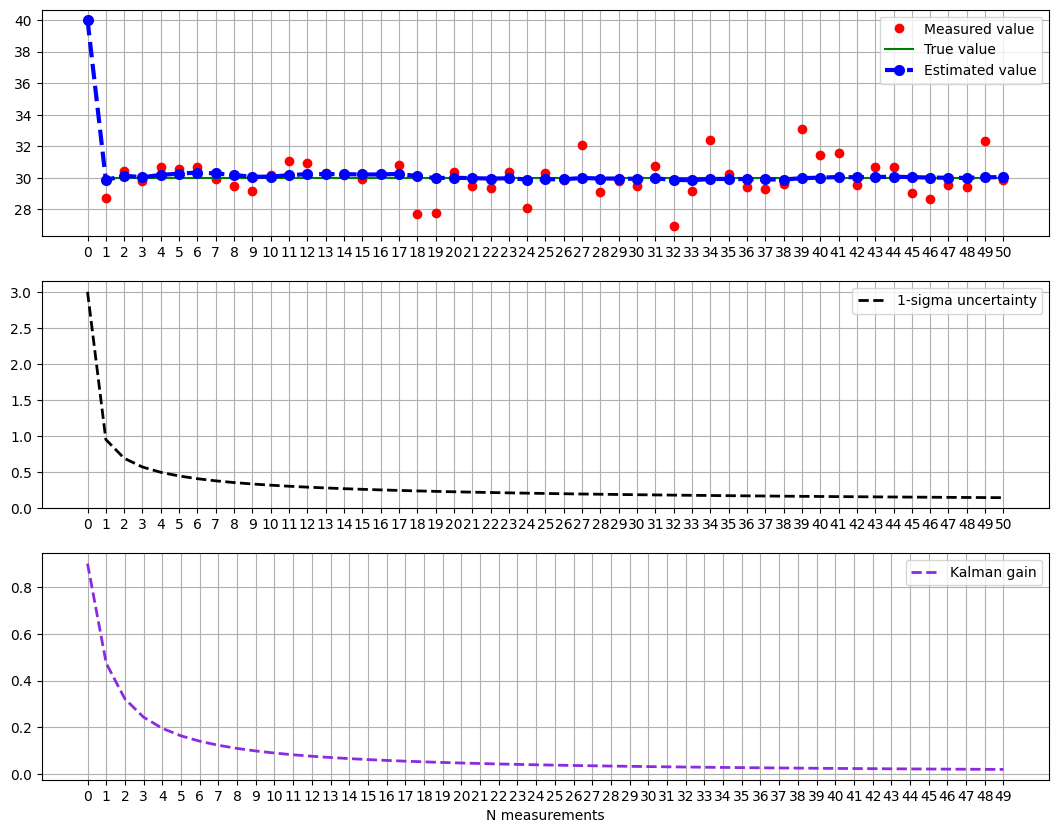

In [2]:
from estimation import *

########## system model ###########
trueTemp      = 30 # °C
###################################

########## meas model #############
oneSigma      = 1   # °C - 1-sigma uncertainty of the measuring device
###################################

########## input data #############
nMeasurements = 50
initialGuess  = 40     # °C 
initialUncertainty = 3 # °C - 1-sigma uncertainty of the initial guess
###################################

OneDimensionalKalman(trueTemp, oneSigma, nMeasurements, initialGuess, initialUncertainty)

Note as an high Kalman gain (close to 1) means that the measure uncertainty is smaller than the overall state estimate uncertainty. Here the filter gives an higher importance to the measurements than the predicted value from the model. When the Kalman Gain is low (close to 0), the measurements have a small weight and the filter gives more importance to the estimated values from the model.
If the measurement uncertainty is equal to the estimate uncertainty, then the Kalman gain equals to 0.5.

<center><img src="Images/kalmanGain.png" alt="Drawing" style="width: 1100px;"/><center>


## Process Noise

Most of the times, when implementing an analytical model to describe how the system evolves over time, we define a *simplified* representation of the reality. For example, we ofter neglect the effect of the air drag while modelling the free fall of an heavy object, or we truncate the infinite number of armonics composing the Earth's gravitational field to a specific number. The net effect is that, due to our ignorance about the system or the difficult to properly model a part of it, we induce a *modelling error* that would eventually lead to completely wrong results.

To avoid such behaviour, we can consider the modelling errors as **process noise**, a random variable with its covariance that *fills* the gap between the model and the reality. Process noise is added on top of the 'deterministic' results of the modelling equations and makes them noisy, as it is a random value (with its covariance)


The process noise is taken into consideration by adding an extra term ($\mathbf{w}$ and $\mathbf{Q}$) to the Kalman filter equations:

--------------------------------------------------------------------------------------------- Prediction ----------------------------------------------------------------------------------
#### $$ \begin{matrix}
\mathbf{x}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{x}_k + \mathbf{w}_k\\
\mathbf{P}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{P}_{k}^P \mathbf{\Phi}_{t_k}^T + \mathbf{Q}_{k+1}\end{matrix}$$

---------------------------------------------------------------------------------------------- Update ------------------------------------------------------------------------------------

#### $$ \begin{matrix}
 \mathbf{K}_{k+1}=\mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T\left ( \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T + \mathbf{R}_{k+1} \right )^{-1} \\
 \mathbf{P}_{k+1}=\mathbf{P}_{k+1}^P - \mathbf{K}_{k+1} \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P \\
 \mathbf{x}_{k+1} = \mathbf{x}_{k+1}^P +\mathbf{K}_{k+1} \left ( \mathbf{y}_{k+1}-\mathbf{H}_{k+1} \mathbf{x}_{k+1}^P\right )
\end{matrix}$$


- $\mathbf{x}$: state vector
- $\mathbf{\Phi}$: state transition matrix
- $\mathbf{w}$: process noise
- $\mathbf{P}$: state covariance matrix
- $\mathbf{Q}$: process noise covariance matrix
- $\mathbf{K}$: Kalman gain
- $\mathbf{R}$: measurement covariance matrix
- $\mathbf{H}$: state to measurement matrix
- $\mathbf{y}$: measurements vector

Note as the process noise and measurement noise are statistically independent.

In the example below we consider again the measurement of the temperature of a body at rest. This time we also imagine that the temperature is changing due to some external effect which is not modeled in the state transition matrix. The following considerations apply:

- Without process noise ($\mathbf{w}=\mathbf{p}=0$), the filter's estimate will diverge from the true temperature value since the measurements don't fit the model anymore
- For a small value of process noise and, for a large number of measurements, a fixed offset (called **lag error**) will be reached
- A large value of process noise inflates the overal uncertainty around the solution, even if it is correctly estimated

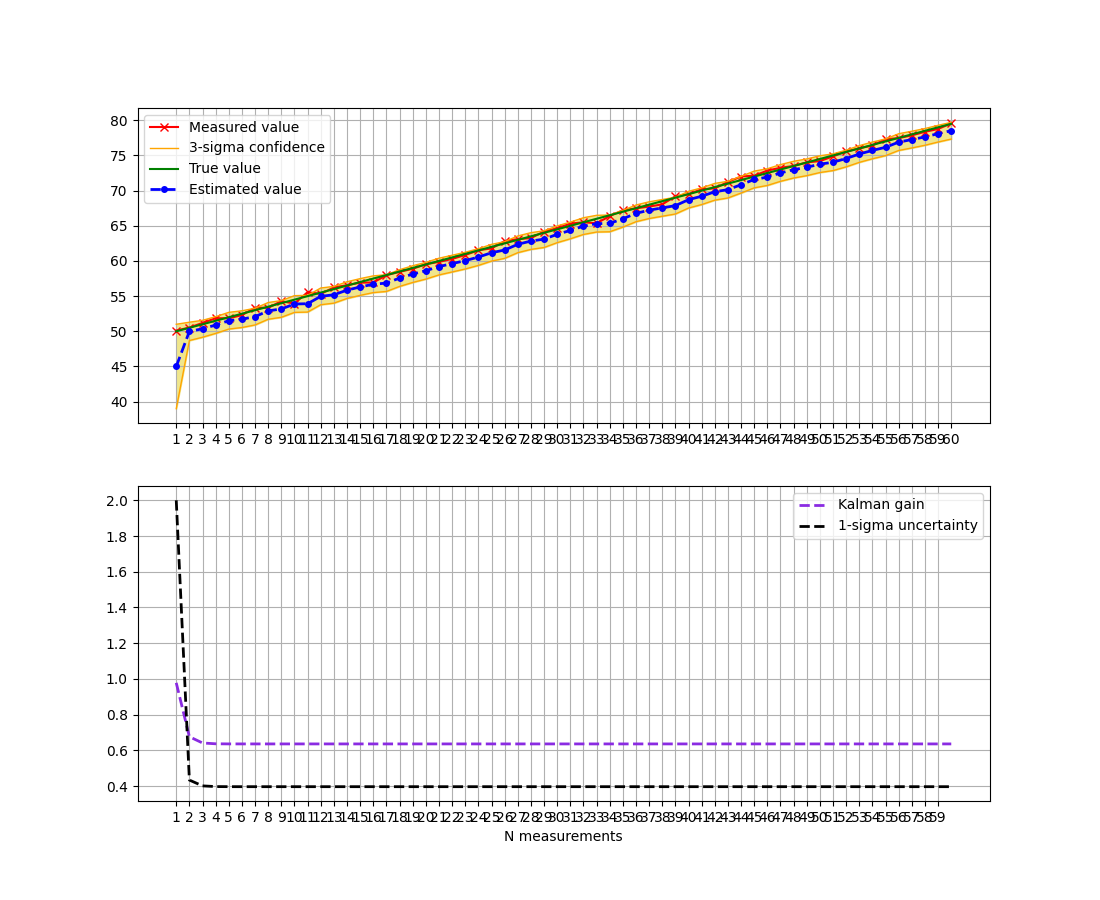

In [3]:
from estimation import *
%matplotlib widget

######### system model ############
initTemp     = 50  # deg
gradientTemp = 0.1 # deg/sec

########## meas model #############
oneSigma      = 0.3   # deg - 1-sigma uncertainty of the measuring device
nMeasurements = 60
timeStep      =   5   # sec - time between measurements
###################################

########## input data #############
initialGuess       = 45     # °C
initialUncertainty = 2      # °C - 1-sigma uncertainty of the initial state
w                  = 0      #0.005  # °C   process noise
q                  = 0.1     #0.05   # °C^2 process noise variance
###################################

KalmanProcessNoise(initTemp, gradientTemp, oneSigma, nMeasurements, timeStep, initialGuess, initialUncertainty, w, q)